In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, SimpleRNN

import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

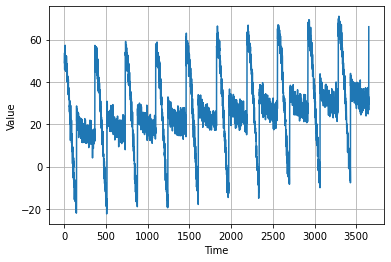

In [5]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plot_series(time, series)

In [6]:
print('train shape : ', x_train.shape)
print('validation shape : ', x_valid.shape)

train shape :  (3000,)
validation shape :  (651,)


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

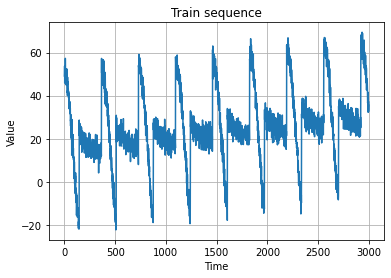

In [8]:
plot_series(time_train, x_train)
plt.title('Train sequence');

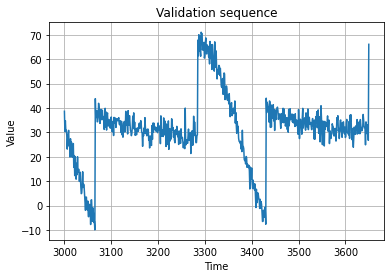

In [9]:
plot_series(time_valid, x_valid)
plt.title('Validation sequence');

In [10]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [12]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.ld = Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None])
    self.rnn1 = SimpleRNN(40, return_sequences=True)
    self.rnn2 = SimpleRNN(40)
    self.d1 = Dense(1)

  def call(self, x):
    x = self.ld(x)
    x = self.rnn1(x)
    x = self.rnn2(x)
    x = self.d1(x)
    return x
  
  def model(self):
    x = Input([window_size])
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [13]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model = MyModel()
model.compile(loss='mse', optimizer=optimizer)
model.model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
lambda (Lambda)              (None, 20, 1)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 20, 40)            1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [14]:
epochs = 100
history = model.fit(train_dataset, epochs = epochs, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 1s 8ms/step - loss: 856.3228
Epoch 2/100
94/94 [==============================] - 1s 7ms/step - loss: 847.1102
Epoch 3/100
94/94 [==============================] - 1s 8ms/step - loss: 838.9210
Epoch 4/100
94/94 [==============================] - 1s 9ms/step - loss: 831.0261
Epoch 5/100
94/94 [==============================] - 1s 9ms/step - loss: 822.6165
Epoch 6/100
94/94 [==============================] - 1s 8ms/step - loss: 813.6901
Epoch 7/100
94/94 [==============================] - 1s 7ms/step - loss: 805.8337
Epoch 8/100
94/94 [==============================] - 1s 8ms/step - loss: 799.2816
Epoch 9/100
94/94 [==============================] - 1s 8ms/step - loss: 793.2189
Epoch 10/100
94/94 [==============================] - 1s 8ms/step - loss: 787.0270
Epoch 11/100
94/94 [==============================] - 1s 8ms/step - loss: 780.4755
Epoch 12/100
94/94 [==============================] - 1s 8ms/step - loss: 773.4252
Epoch 13/100


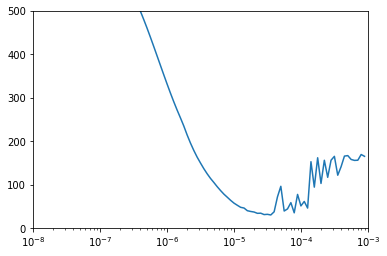

In [15]:
plt.semilogx(1e-8 * (10 ** (np.arange(100) / 20)), history.history['loss'][:100])
plt.axis([1e-8, 1e-3, 0, 500]);

In [16]:
argmin = tf.argmin(history.history['loss']).numpy()
argmin

71

In [17]:
new_lr = 1e-8 * (10 ** ((argmin+1) / 20))
new_lr

3.9810717055349735e-05

In [18]:
optimizer = tf.keras.optimizers.SGD(lr=new_lr, momentum=0.9)

model = MyModel()
model.compile(loss='mse', optimizer=optimizer)
model.model().summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 20, 1)             0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [19]:
epochs = 500
history = model.fit(train_dataset, epochs = epochs)

Epoch 1/500
94/94 [==============================] - 1s 9ms/step - loss: 292.8562
Epoch 2/500
94/94 [==============================] - 1s 9ms/step - loss: 100.9428
Epoch 3/500
94/94 [==============================] - 1s 7ms/step - loss: 58.7929
Epoch 4/500
94/94 [==============================] - 1s 8ms/step - loss: 42.7168
Epoch 5/500
94/94 [==============================] - 1s 7ms/step - loss: 35.4646
Epoch 6/500
94/94 [==============================] - 1s 8ms/step - loss: 32.6577
Epoch 7/500
94/94 [==============================] - 1s 9ms/step - loss: 42.5389
Epoch 8/500
94/94 [==============================] - 1s 9ms/step - loss: 43.5362
Epoch 9/500
94/94 [==============================] - 1s 9ms/step - loss: 45.2015
Epoch 10/500
94/94 [==============================] - 1s 9ms/step - loss: 37.2717
Epoch 11/500
94/94 [==============================] - 1s 8ms/step - loss: 42.3479
Epoch 12/500
94/94 [==============================] - 1s 7ms/step - loss: 39.3979
Epoch 13/500
94/94 [===

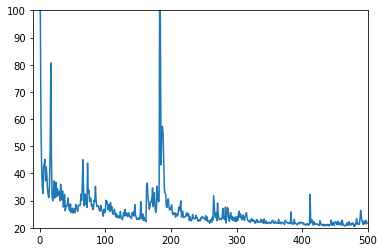

In [29]:
plt.plot(history.history['loss'])
plt.axis([-10, 500, 20, 100]);

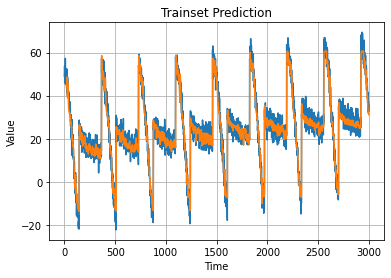

In [30]:
train_dataset = windowed_dataset(x_train, window_size, batch_size, 1)
train_preds = np.array([])
for i in train_dataset:
  train_preds = np.append(train_preds, model(i[0]).numpy())
plot_series(time_train, x_train)
plot_series(time_train[20:], train_preds)
plt.title('Trainset Prediction');

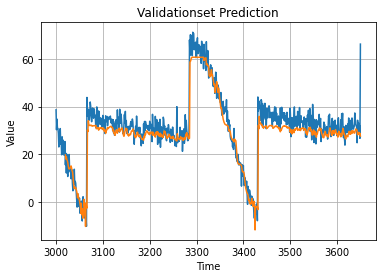

In [31]:
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, 1)
valid_preds = np.array([])
for i in valid_dataset:
  valid_preds = np.append(valid_preds, model(i[0]).numpy())
plot_series(time_valid, x_valid)
plot_series(time_valid[20:], valid_preds)
plt.title('Validationset Prediction');

In [32]:
print('Train MAE : ', tf.keras.metrics.mean_absolute_error(x_train[20:], train_preds).numpy())
print('Validation MAE : ', tf.keras.metrics.mean_absolute_error(x_valid[20:], valid_preds).numpy())

Train MAE :  3.081947398600762
Validation MAE :  3.7888936396162785
